# Set the file paths
In the cell with TSV_FILE_PATH set the path to tsv file and the path to the files corresponding to the correct experiment number. Only the prefix is required and not the full file names. Afterwards run the cell to set the variables (Press play button while selected).

**NOTE:** the paths should either be absolute paths (c:/Users/enzomo/Downloads/enzo_data/...) or from the current directory. Execute the cell below to see the current directory.

In [245]:
import os

os.getcwd()

'/Users/patbu/Desktop/ecms_script'

In [246]:
# FILL in path to tsv file
# TSV_FILE_PATH="20240821_AuCu7525/2024-08-22 10_39_53 Full Test/2024-08-22 10_39_53 Full Test.tsv"
TSV_FILE_PATH="20240905_VSP_Au_4nm_2_5min_1M_KHCO3/2024-09-10 16_49_03 Full Test/2024-09-10 16_49_03 Full Test.tsv"

# FILL in path to experiment number files
# EXPT_NUM_FILE_PATH="20240821_AuCu7525/2024-08-22 10_39_53 Full Test/10"
EXPT_NUM_FILE_PATH="20240905_VSP_Au_4nm_2_5min_1M_KHCO3/03__02_CP"

In [247]:
from ixdat import Measurement

ms = Measurement.read(
    TSV_FILE_PATH,
    reader="zilien",
    technique="MS"
)

# ms.plot()

ec = Measurement.read_set(
    EXPT_NUM_FILE_PATH,
    suffix=".mpt")

# ec.plot()


ecms = ec + ms
# ecms["raw_potential"]._data = ecms["<Ewe/V>"]._data # fix for raw_potential being always 0 (not read correctly) 
ecms["raw_potential"]._data = ecms["<Ewe/V>"]._data



In [248]:
ecms.t[0]

ecms.tstamp += ecms.t[0] - 1

# Plot ecms

Text(0.5, 0.98, '2024-09-10 16_49_03 Full Test.tsv')

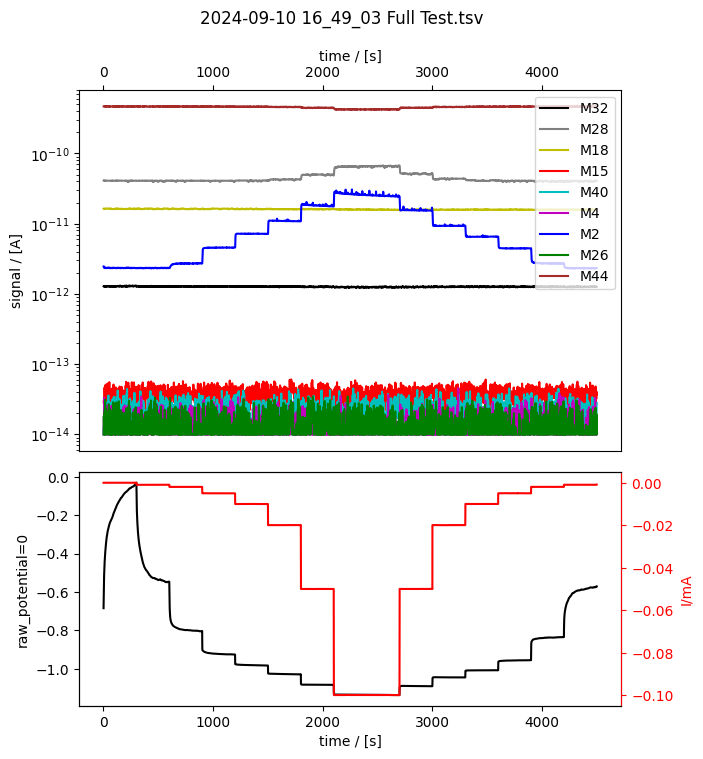

In [249]:
axes = ecms.plot()
fig = axes[0].get_figure()
fig.set_size_inches(
    7, # figure width
    8, # figure height
    forward=True
)



axes[0].legend(
    loc="upper right" # uncomment to change legend position
)

fig.suptitle(os.path.basename(TSV_FILE_PATH))


# FILL IN: Parameters for Calculating Faradaic Efficiency
set the parameters required for processing the data below. Importantly require the step length for each applied current and the steps (starting from step 0) to calculate faradaic efficiency of CO2RR. Also, provide either the calibration factor and MS background current for H2 reduction (HER) or else the steps/times that should be used to calculate it. Optionally provide the start time (if not 0) and the time prior to end of step to average over for calculations.

In [250]:
STEP_TIME = 300 # seconds
CO2RR_STEPS = [6, 7, 8, 9, 10, 11, 12, 13, 14] # step number in current sequence/program, first step is 1

# fill in one of the following
HER_STEPS = [3, 4, 5,] # for calculating the calibration factor from raw_current to ms H2 current
HER_CALIBRATION_FACTOR = None

# fill in one of the following
HER_BACKGROUND_TIME_INTERVAL = [5100, 5200] # for calculating the background current of the ms
HER_BACKGROUND_CURRENT = None

TIME_AMOUNT_AVERAGE_OVER = 100 # seconds
START_TIME = 0 # if want to start steps from a time other that t=0


# parameter check
assert CO2RR_STEPS, "must provide step numbers (from zero) to calculate CO2RR faradaic efficiency for"
assert HER_STEPS or HER_CALIBRATION_FACTOR is not None, "must provide HER calibration factor OR the step numbers for calculating it"
assert HER_BACKGROUND_TIME_INTERVAL or HER_BACKGROUND_CURRENT is not None, "must provide H2 MS background current OR time interval to calculate it"

### Optional: Add electrode details

In [251]:
# ecms["raw_potential"]._data = meas["<Ewe/V>"]._data
ecms.calibrate( # do this first
    RE_vs_RHE=0, # if use RHE reference electrode assume that the potential difference between our reference electrode and the RHE potential is zero.
    A_el=0.196, # We know the geometric area of the electrode, so we can normalize the current: it’s a 5mm diameter disk, area = 0.196 cm^2
    R_Ohm=0, # We did not determine the Ohmic drop, but we will assume that it was 0 
)

### Calculate HER background current if required

In [252]:
# def calc_HER_MS_background_current(ecms):
#     pass



if HER_BACKGROUND_CURRENT is None:
    times, currents = ecms.grab(item="M2 [A]", tspan=HER_BACKGROUND_TIME_INTERVAL)
    # M2_ave_current = M2_current.mean()
    HER_BACKGROUND_CURRENT = currents.mean()

print(HER_BACKGROUND_CURRENT)

2.3186923225806456e-12


### Calculate HER calibration factor if required

MSCalResult(name=H2@M2, mol=H2, mass=M2, F=0.10608444263929312)


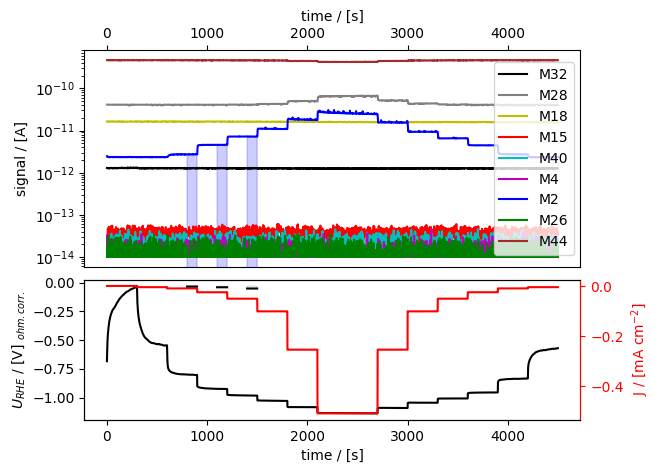

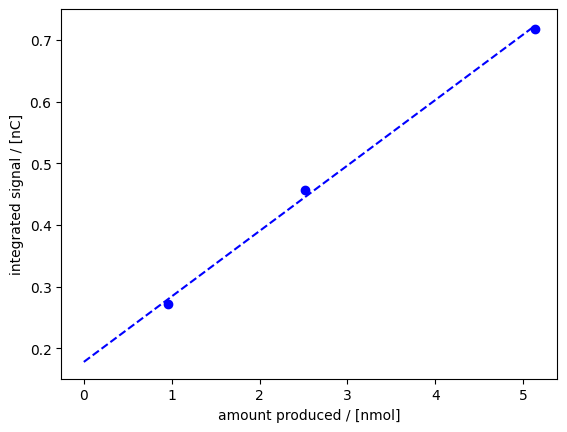

In [253]:
if HER_CALIBRATION_FACTOR is None:
    
    axes = ecms.plot()
    cal_result_H2, ax_b2 = ecms.ecms_calibration_curve(
        mol="H2",
        mass="M2",
        n_el=-2, # remember to use the correct sign: minus for reduction reactions, plus for oxidation reactions
        tspan_list=[
            (START_TIME + STEP_TIME*(x)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x))
            for x in HER_STEPS
        ],
        # tspan_bg=(5000, 5100),
        ax="new",
        axes_measurement=axes, # to highlight the integrated areas on the plot defined above
        return_ax = True # if True, returns the calibration curve axis as a second element
    )
    print(cal_result_H2)  # prints: MSCalResult(name="H2@M2", mol="H2", mass="M2", F=0.34)
    HER_CALIBRATION_FACTOR=cal_result_H2.F # The attribute cal_result_H2.F is the slope of the calibration curve, which is the sensitivity factor in C/mol. 


# def calc_HER_calibration_factor(ecms):
#     pass

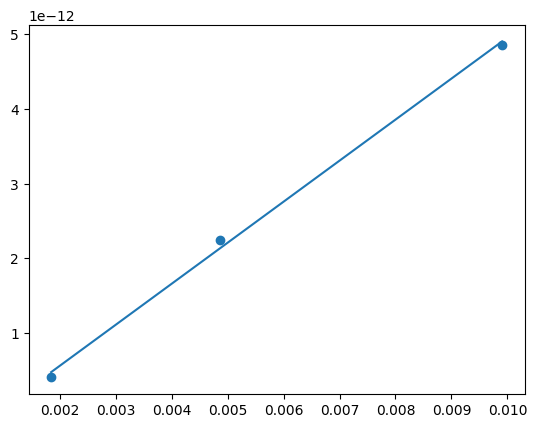

In [254]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# if HER_CALIBRATION_FACTOR is None:

HER_calibration_intervals = [
    (START_TIME + STEP_TIME*(x)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x))
    for x in HER_STEPS
]

raw_currents, HER_currents = [], []

for interval in HER_calibration_intervals:
    raw_currents.append(
        ecms.grab(item="raw_current", tspan=interval)[1].mean(),
    )
    HER_currents.append(
        ecms.grab(item="M2 [A]", tspan=interval)[1].mean(),
    )


# x = [abs(x[1]) for x in currents] # should this be negative x?
# y = [abs(x[0]) for x in currents] # because 2 electrons for each H2 molecule?

raw_currents = np.abs(np.array(raw_currents))
HER_currents = np.array(HER_currents) - HER_BACKGROUND_CURRENT

plt.scatter(
    raw_currents,
    HER_currents,
)


m, b = np.polyfit(
    raw_currents,
    HER_currents,
    1
)

m, b

# m = np.mean(HER_currents/applied_currents)

plt.plot(
    raw_currents,
    [m*v+b for v in raw_currents]
)

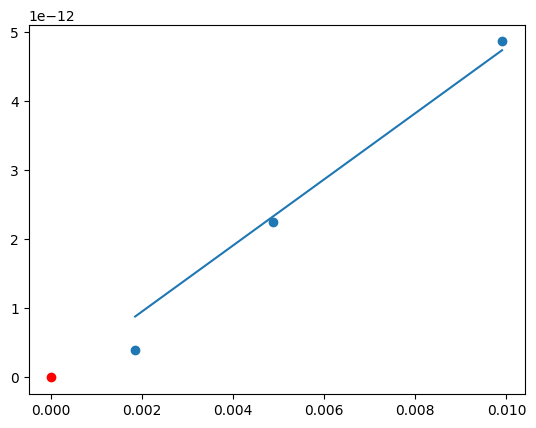

In [269]:
x = raw_currents
y = HER_currents
x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.scatter(
    x,
    y,
)
plt.scatter(
    [0], [0], c='r'
)

plt.plot(
    raw_currents,
    [a[0]*v for v in raw_currents]
)

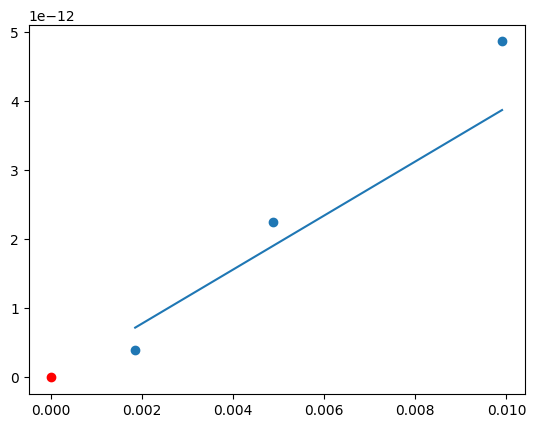

In [270]:
m2 = np.mean(HER_currents/raw_currents)

x = raw_currents
y = HER_currents
# x = x[:,np.newaxis]
# a, _, _, _ = np.linalg.lstsq(x, y)

plt.scatter(
    x,
    y,
)
plt.scatter(
    [0], [0], c='r'
)

plt.plot(
    raw_currents,
    [m2*v for v in raw_currents]
)

# Calculate CO2RR Faradaic Efficiencies

In [257]:
m, b, a[0]

(np.float64(5.497622514828437e-10),
 np.float64(-5.389482635843181e-13),
 np.float64(4.782253948610668e-10))

In [258]:
from ixdat.constants import FARADAY_CONSTANT

FARADAY_CONST =9.64853321233100184E4 # C / mol

def convert_HER_current_by_calibration_factor(cur):
    """
    calibration factor = MS_current / molar_flux 
    and
    molar_flux = raw_current/(z*F), where z is electron per molecule and F is Faraday const
    hence
    MS_current = calibration_factor * (raw_current/zF)
    """
    return HER_CALIBRATION_FACTOR*(cur/(2*FARADAY_CONSTANT)) 


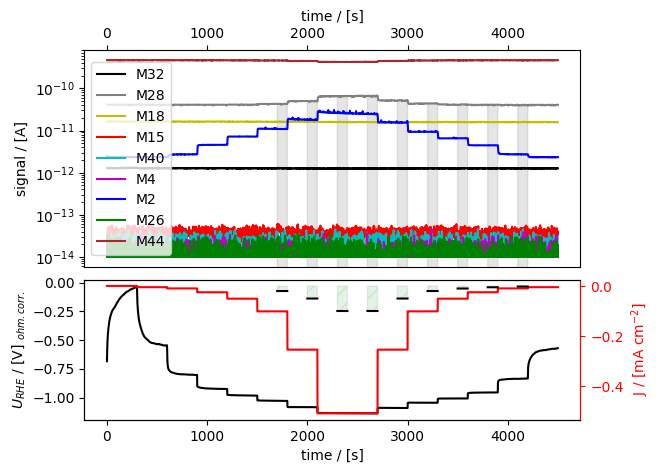

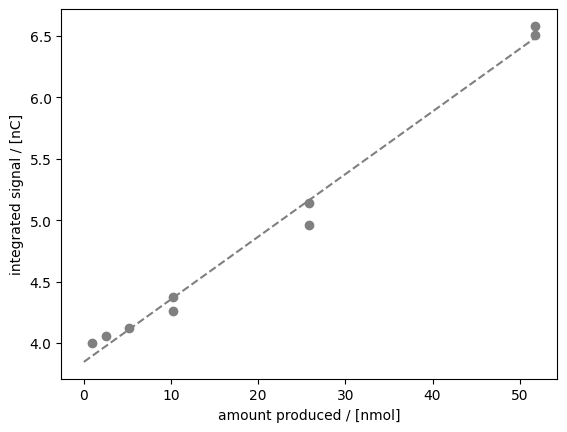

In [259]:
CO2RR_intervals = [
    (START_TIME + STEP_TIME*(x)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x))
    for x in CO2RR_STEPS
]

axes = ecms.plot()
cal_result_H2, ax_b2 = ecms.ecms_calibration_curve(
    mol="CO",
    mass="M28",
    n_el=-2, # remember to use the correct sign: minus for reduction reactions, plus for oxidation reactions
    tspan_list=CO2RR_intervals,
    # tspan_bg=(5000, 5100),
    ax="new",
    axes_measurement=axes, # to highlight the integrated areas on the plot defined above
    return_ax = True # if True, returns the calibration curve axis as a second element
)
# print(cal_result_H2)  # prints: MSCalResult(name="H2@M2", mol="H2", mass="M2", F=0.34)
# HER_CALIBRATION_FACTOR=cal_result_H2.F # The attribute cal_result_H2.F is the slope of the calibration curve, which is the sensitivity factor in C/mol. 
fig = ax_b2.get_figure()

### Faradaic Efficiency using calibration factor

In [260]:
data1 = []
for interval in CO2RR_intervals:
    HER_current = ecms.grab(item="M2 [A]", tspan=interval)[1].mean()# - HER_BACKGROUND_CURRENT
    raw_current = ecms.grab(item="raw_current", tspan=interval)[1].mean()

    # print(raw_current, HER_CALIBRATION_FACTOR, FARADAY_CONSTANT)
    
    cell_current = (HER_CALIBRATION_FACTOR*np.abs(raw_current))/(2*FARADAY_CONSTANT)
    CO2RR_current = cell_current - HER_current
    faradaic_efficiency = (CO2RR_current / cell_current) * 100
    
    data1.append([interval[0], interval[1], cell_current, HER_current, CO2RR_current, faradaic_efficiency])

data1 = pd.DataFrame(data1, columns=["start (s)", "end (s)", "cell current", "HER current", "CO2RR current", "Faradaic Efficiency"])

### Faradaic Efficiency using rank-0 linear fit (y=mx)

In [261]:
data2 = []
for interval in CO2RR_intervals:
    HER_current = ecms.grab(item="M2 [A]", tspan=interval)[1].mean() - HER_BACKGROUND_CURRENT
    raw_current = ecms.grab(item="raw_current", tspan=interval)[1].mean()
    
    cell_current = np.abs(raw_current) * a[0]
    CO2RR_current = cell_current - HER_current
    faradaic_efficiency = (CO2RR_current / cell_current) * 100
    
    data2.append([interval[0], interval[1], cell_current, HER_current, CO2RR_current, faradaic_efficiency])

data2 = pd.DataFrame(data2, columns=["start (s)", "end (s)", "cell current", "HER current", "CO2RR current", "Faradaic Efficiency"])

### Faradaic Efficiency using rank-1 linear fit (y=mx+b)

In [262]:
data3 = []
for interval in CO2RR_intervals:
    HER_current = ecms.grab(item="M2 [A]", tspan=interval)[1].mean() - HER_BACKGROUND_CURRENT
    raw_current = ecms.grab(item="raw_current", tspan=interval)[1].mean()
    
    cell_current = np.abs(raw_current) * m #+ b
    CO2RR_current = cell_current - HER_current
    faradaic_efficiency = (CO2RR_current / cell_current) * 100
    
    data3.append([interval[0], interval[1], cell_current, HER_current, CO2RR_current, faradaic_efficiency])

data3 = pd.DataFrame(data3, columns=["start (s)", "end (s)", "cell current", "HER current", "CO2RR current", "Faradaic Efficiency"])

In [373]:
data4 = []
for interval in CO2RR_intervals:
    HER_current = ecms.grab(item="M2 [A]", tspan=interval)[1].mean() - HER_BACKGROUND_CURRENT
    raw_current = ecms.grab(item="raw_current", tspan=interval)[1].mean()
    
    cell_current = np.abs(raw_current) * m + b
    CO2RR_current = cell_current - HER_current
    faradaic_efficiency = (CO2RR_current / cell_current) * 100
    
    data4.append([interval[0], interval[1], cell_current, HER_current, CO2RR_current, faradaic_efficiency])

data4 = pd.DataFrame(data4, columns=["start (s)", "end (s)", "cell current", "HER current", "CO2RR current", "Faradaic Efficiency"])

### Faradaic efficiency using average correlation

In [264]:
data5 = []
for interval in CO2RR_intervals:
    HER_current = ecms.grab(item="M2 [A]", tspan=interval)[1].mean() - HER_BACKGROUND_CURRENT
    raw_current = ecms.grab(item="raw_current", tspan=interval)[1].mean()
    
    cell_current = np.abs(raw_current) * m2
    CO2RR_current = cell_current - HER_current
    faradaic_efficiency = (CO2RR_current / cell_current) * 100
    
    data5.append([interval[0], interval[1], cell_current, HER_current, CO2RR_current, faradaic_efficiency])

data5 = pd.DataFrame(data5, columns=["start (s)", "end (s)", "cell current", "HER current", "CO2RR current", "Faradaic Efficiency"])

### Comparison

In [272]:
overall_data = data1.iloc[:, :2]

overall_data["calibration_factor_FE"] = data1["Faradaic Efficiency"]
overall_data["rank_0_fit_FE"] = data2["Faradaic Efficiency"]
overall_data["rank_1_fit_FE"] = data3["Faradaic Efficiency"]
overall_data["rank_1_fit2_FE"] = data4["Faradaic Efficiency"]
overall_data["ave_scaling_factor_FE"] = data5["Faradaic Efficiency"]

overall_data

,start (s),end (s),calibration_factor_FE,rank_0_fit_FE,rank_1_fit_FE,rank_1_fit2_FE,ave_scaling_factor_FE
0,1700,1800,99.900418,9.970422,21.685364,17.613439,-10.161256
1,2000,2100,99.934712,34.668468,43.169620,42.030346,20.059565
2,2300,2400,99.952675,50.455791,56.902645,56.475088,39.377121
3,2600,2700,99.955008,53.137111,59.235063,58.830682,42.658015
4,2900,3000,99.943622,44.910738,52.079132,51.118419,32.592128
5,3200,3300,99.914416,26.059287,35.680694,32.336842,9.525269
6,3500,3600,99.879756,10.769037,22.380061,13.845162,-9.184061
7,3800,3900,99.832837,7.888769,19.874583,-0.444905,-12.708392
8,4100,4200,99.731178,54.356919,60.296146,15.066017,44.150586


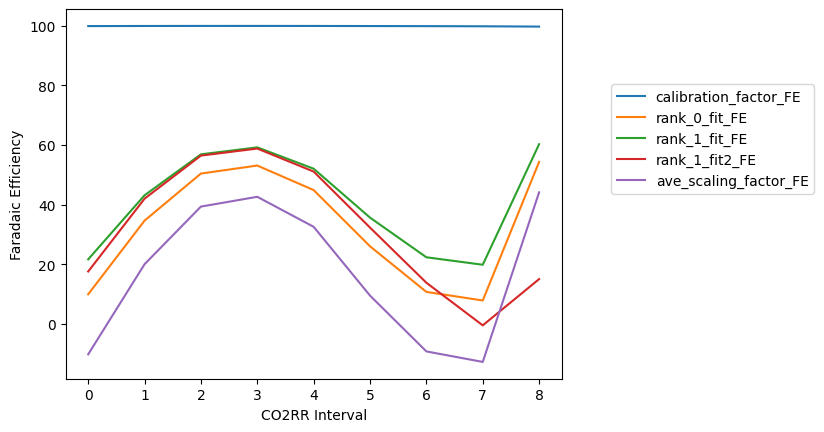

In [266]:
plt.plot(
    overall_data.iloc[:, 5:],
    label=overall_data.columns[5:]
)

plt.ylabel("Faradaic Efficiency")
plt.xlabel("CO2RR Interval")

plt.legend(loc=(1.1, 0.5))

### Output csv

In [330]:
mass_list = sorted(ecms.mass_list, key=lambda x: float(x[1:]))

mass_to_species = {}

all_intervals = [
    (START_TIME + STEP_TIME*(x+1)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x+1))
    for x in range(ecms.selector._data[-1] + 1)
]


all_currents = []
for interval in all_intervals:
    interval_currents = []
    for mass in mass_list:
        interval_currents.append(ecms.grab(f"{mass} [A]", tspan=interval)[1].mean())

    all_currents.append(interval_currents)


all_currents

output_data = pd.DataFrame(all_currents, columns=mass_list)

In [331]:
all_intervals

[(200, 300),
 (500, 600),
 (800, 900),
 (1100, 1200),
 (1400, 1500),
 (1700, 1800),
 (2000, 2100),
 (2300, 2400),
 (2600, 2700),
 (2900, 3000),
 (3200, 3300),
 (3500, 3600),
 (3800, 3900),
 (4100, 4200)]

In [351]:
faradaic_efficiencies = [0 for _ in range(ecms.selector._data[-1] + 1)]
d = data3["Faradaic Efficiency"].to_list()


# for i in CO2RR_STEPS:
    # print(i)
    # print(faradaic_efficiencies[i-1])
    # print(float(data3["Faradaic Efficiency"].iloc[i-CO2RR_STEPS[0]]))
    # faradaic_efficiency[i-1] = float(data3["Faradaic Efficiency"][i-CO2RR_STEPS[0]]
    # faradaic_efficiency[i-1] = 

    # pd.concat((output_data, pd.DataFrame(faradaic_efficiencies)), axis=1)

<class 'list'>


In [319]:
faradaic_efficiencies

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [352]:
data1

,start (s),end (s),cell current,HER current,CO2RR current,Faradaic Efficiency
0,1700,1800,1.090408e-08,1.085847e-11,1.089322e-08,99.900418
1,2000,2100,2.742238e-08,1.790345e-11,2.740447e-08,99.934712
2,2300,2400,5.486249e-08,2.596377e-11,5.483653e-08,99.952675
3,2600,2700,5.486753e-08,2.468615e-11,5.484285e-08,99.955008
4,2900,3000,2.742104e-08,1.545953e-11,2.740558e-08,99.943622
5,3200,3300,1.090530e-08,9.333143e-12,1.089597e-08,99.914416
6,3500,3600,5.440187e-09,6.541503e-12,5.433646e-09,99.879756
7,3800,3900,2.664083e-09,4.453371e-12,2.659630e-09,99.832837
8,4100,4200,1.012013e-09,2.720514e-12,1.009293e-09,99.731178


In [353]:
data2

,start (s),end (s),cell current,HER current,CO2RR current,Faradaic Efficiency
0,1700,1800,9.485525e-12,8.539778e-12,9.457469e-13,9.970422
1,2000,2100,2.385489e-11,1.558476e-11,8.270124e-12,34.668468
2,2300,2400,4.772520e-11,2.364507e-11,2.408013e-11,50.455791
3,2600,2700,4.772958e-11,2.236746e-11,2.536212e-11,53.137111
4,2900,3000,2.385372e-11,1.314084e-11,1.071288e-11,44.910738
5,3200,3300,9.486588e-12,7.014451e-12,2.472137e-12,26.059287
6,3500,3600,4.732450e-12,4.222811e-12,5.096393e-13,10.769037
7,3800,3900,2.317501e-12,2.134679e-12,1.828223e-13,7.888769
8,4100,4200,8.803563e-13,4.018217e-13,4.785345e-13,54.356919


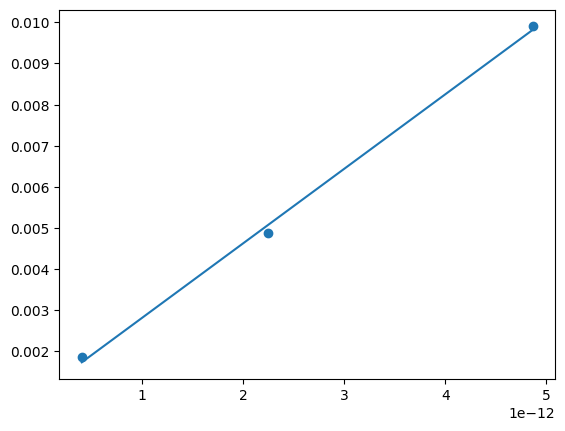

In [356]:
# import numpy as np
# import pandas as pd 
# import matplotlib.pyplot as plt
# if HER_CALIBRATION_FACTOR is None:

HER_calibration_intervals = [
    (START_TIME + STEP_TIME*(x)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x))
    for x in HER_STEPS
]

raw_currents, HER_currents = [], []

for interval in HER_calibration_intervals:
    raw_currents.append(
        ecms.grab(item="raw_current", tspan=interval)[1].mean(),
    )
    HER_currents.append(
        ecms.grab(item="M2 [A]", tspan=interval)[1].mean(),
    )


# x = [abs(x[1]) for x in currents] # should this be negative x?
# y = [abs(x[0]) for x in currents] # because 2 electrons for each H2 molecule?

raw_currents = np.abs(np.array(raw_currents))
HER_currents = np.array(HER_currents) - HER_BACKGROUND_CURRENT

plt.scatter(
    HER_currents,
    raw_currents,
)


m, b = np.polyfit(
    HER_currents,
    raw_currents,
    1
)

m, b

# m = np.mean(HER_currents/applied_currents)

plt.plot(
    HER_currents,
    [m*v+b for v in HER_currents]
)

In [357]:
m, b

(np.float64(1815330155.6724026), np.float64(0.0009894458484527831))

In [371]:
data6 = []
for interval in CO2RR_intervals:
    HER_current = ecms.grab(item="M2 [A]", tspan=interval)[1].mean() - HER_BACKGROUND_CURRENT
    raw_current = ecms.grab(item="raw_current", tspan=interval)[1].mean()
    
    HER_cell_current = np.abs(HER_current) * m + b
    CO2RR_current = np.abs(raw_current) - HER_cell_current
    faradaic_efficiency = (CO2RR_current / np.abs(raw_current)) * 100
    
    data6.append([interval[0], interval[1], cell_current, HER_current, HER_cell_current, CO2RR_current, faradaic_efficiency])

data6 = pd.DataFrame(data4, columns=["start (s)", "end (s)", "cell current", "HER MS current", "HER_cell_current", "CO2RR current", "Faradaic Efficiency"])

In [372]:
data6

,start (s),end (s),cell current,HER MS current,HER_cell_current,CO2RR current,Faradaic Efficiency
0,1700,1800,7.194735e-13,8.539778e-12,0.016492,0.003343,16.853571
1,2000,2100,7.194735e-13,1.558476e-11,0.029281,0.020601,41.299712
2,2300,2400,7.194735e-13,2.364507e-11,0.043913,0.055883,55.997377
3,2600,2700,7.194735e-13,2.236746e-11,0.041594,0.058212,58.325220
4,2900,3000,7.194735e-13,1.314084e-11,0.024844,0.025035,50.191308
5,3200,3300,7.194735e-13,7.014451e-12,0.013723,0.006114,30.821468
6,3500,3600,7.194735e-13,4.222811e-12,0.008655,0.001241,12.536715
7,3800,3900,7.194735e-13,2.134679e-12,0.004865,-0.000019,-0.382767
8,4100,4200,7.194735e-13,4.018217e-13,0.001719,0.000122,6.627072


,start (s),end (s),cell current,HER current,CO2RR current,Faradaic Efficiency
0,1700,1800,9.485525e-12,8.539778e-12,9.457469e-13,9.970422
1,2000,2100,2.385489e-11,1.558476e-11,8.270124e-12,34.668468
2,2300,2400,4.772520e-11,2.364507e-11,2.408013e-11,50.455791
3,2600,2700,4.772958e-11,2.236746e-11,2.536212e-11,53.137111
4,2900,3000,2.385372e-11,1.314084e-11,1.071288e-11,44.910738
5,3200,3300,9.486588e-12,7.014451e-12,2.472137e-12,26.059287
6,3500,3600,4.732450e-12,4.222811e-12,5.096393e-13,10.769037
7,3800,3900,2.317501e-12,2.134679e-12,1.828223e-13,7.888769
8,4100,4200,8.803563e-13,4.018217e-13,4.785345e-13,54.356919
